In [1]:
# importing torch libraries
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

# Data science tools
import numpy as np
import pandas as pd
import os
import glob

# Image manipulations
from PIL import Image
import cv2

from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from torch import Tensor, nn
from torch.nn.functional import interpolate

#MISC
import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# checking if GPU is available
if torch.cuda.is_available():
   print ("Cuda is available")
   device_id = torch.cuda.current_device()
   gpu_properties = torch.cuda.get_device_properties(device_id)
   print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
          "%.1fGb total memory.\n" % 
          (torch.cuda.device_count(),
          device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))
else:    
   print ("Cuda is not available")

Cuda is available
Found 1 GPUs available. Using GPU 0 (Tesla K80) of compute capability 3.7 with 12.0Gb total memory.



In [3]:
# setting GPU depending on availability
device = torch.device('cuda')

In [4]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"
batch_size = 40

# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=2),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=2),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=2)
}

# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features, labels = features.to(device), labels.to(device)
features.shape, labels.shape

(torch.Size([40, 3, 224, 224]), torch.Size([40]))

In [6]:
categories = []
for d in os.listdir(traindir):
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')
print(categories)

There are 11 different classes.
['0100000000', '0000000001', '1000000000', '0000000100', '0000000010', '0000010000', '0000000000', '0001000000', '0000100000', '0010000000', '0000001000']


In [7]:
vgg16 = models.vgg16(pretrained = True)
new_classifier = nn.Sequential(*(list(vgg16.classifier.children())[:-1] + [nn.Linear(in_features = 4096, out_features = 11)]))
vgg16.classifier = new_classifier
model = vgg16
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma = 0.3)

In [8]:
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [9]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            output = output.to(device)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    data = data.to(device)
                    target = target.to(device)

                    # Forward pass
                    output = model(data)
                    output = output.to(device)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history, correct_tensor

In [10]:
save_file_name = f'vgg16-transfer-hsv.pt'
checkpoint_path = f'vgg16-transfer-hsv.pth'

model, history, correct_tensor = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=50,
    n_epochs=5,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 233.36 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 2.4132 	Validation Loss: 2.3916
		Training Accuracy: 9.44%	 Validation Accuracy: 12.74%
Epoch: 1	100.00% complete. 231.54 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 2.2984 	Validation Loss: 1.7535
		Training Accuracy: 16.67%	 Validation Accuracy: 41.02%
Epoch: 2	100.00% complete. 231.09 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.1243 	Validation Loss: 0.6394
		Training Accuracy: 60.16%	 Validation Accuracy: 79.13%
Epoch: 3	100.00% complete. 231.14 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5467 	Validation Loss: 0.4948
		Training Accuracy: 80.89%	 Validation Accuracy: 83.60%
Epoch: 4	100.00% complete. 232.17 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.4086 	Validation Loss: 0.4219
		Training Accuracy: 85.79%	 Validation Accuracy: 85.03%

Best epoch: 4 with loss: 0.42 and acc: 85.03%
1380.14 total seconds elapsed. 345.04 seconds per e

In [11]:
class_number = 11
model.load_state_dict(torch.load('vgg16-transfer.pt'))
confusion_matrix = torch.zeros(class_number, class_number)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs).to(device)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[184.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2., 183.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,   6., 182.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  3.,   0.,   7., 179.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   8.,   0., 174.,   4.,   0.,   4.,   0.,   2.,   0.],
        [  1.,   0.,   6.,   0.,   0., 127.,  46.,   0.,   4.,   0.,   0.],
        [  1.,   0.,   2.,   0.,   0.,   0., 174.,   0.,  15.,   0.,   0.],
        [ 17.,   0.,   7.,   0.,   0.,   0.,   2., 153.,   0.,  13.,   0.],
        [ 18.,   0.,   5.,   0.,   0.,   0.,   0.,   0., 155.,   0.,  14.],
        [ 47.,   0.,   5.,   0.,   0.,   0.,   0.,   3.,   2., 135.,   0.],
        [ 47.,   0.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 136.]])


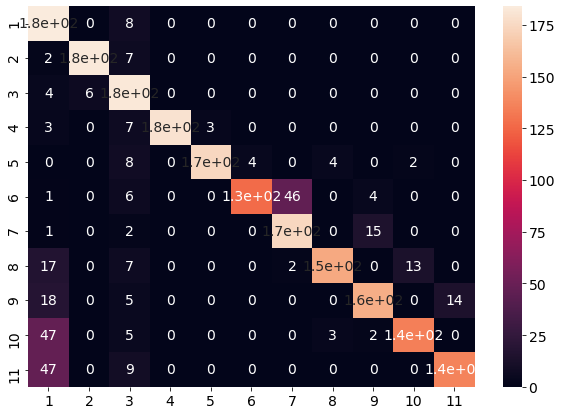

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[184.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2., 183.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  4.,   6., 182.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  3.,   0.,   7., 179.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   8.,   0., 174.,   4.,   0.,   4.,   0.,   2.,   0.],
        [  1.,   0.,   6.,   0.,   0., 127.,  46.,   0.,   4.,   0.,   0.],
        [  1.,   0.,   2.,   0.,   0.,   0., 174.,   0.,  15.,   0.,   0.],
        [ 17.,   0.,   7.,   0.,   0.,   0.,   2., 153.,   0.,  13.,   0.],
        [ 18.,   0.,   5.,   0.,   0.,   0.,   0.,   0., 155.,   0.,  14.],
        [ 47.,   0.,   5.,   0.,   0.,   0.,   0.,   3.,   2., 135.,   0.],
        [ 47.,   0.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 136.]]

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5,6,7,8,9,10,11]],
                  columns = [i for i in [1,2,3,4,5,6,7,8,9,10,11]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')

In [13]:
# from https://github.com/vickyliin/gradcam_plus_plus-pytorch

layer_finders = {}


def register_layer_finder(model_type):
    def register(func):
        layer_finders[model_type] = func
        return func
    return register


def visualize_cam(mask, img, alpha=0.5):
    
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


@register_layer_finder('vgg')
def find_vgg_layer(arch, target_layer_name):
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)


def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)

    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)

    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class GradCAM:

    def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module):
        self.model_arch = arch

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model_arch(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)
    
class GradCAMpp(GradCAM):


    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']  # dS/dA
        activations = self.activations['value']  # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = alpha_num.mul(2) + activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients)  # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

In [35]:
for filename in glob.glob('data/test/1000000000/*.jpg'):
    pil_img = Image.open(filename)
    
#for image in dataloaders['test']:
    
    torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(pil_img)
    normed_torch = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)
    normed_torch_img = normed_torch[None, :, :, :]
    normed_torch_img = normed_torch_img.to(device)
    print(normed_torch_img.shape)
    vgg = model
    vgg = model.to(device)
    
    configs = [
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    ]


    cams = [
        [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
        for config in configs
    ]

    images = []
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(normed_torch_img)
        mask = mask.to(device)
        heatmap, result = visualize_cam(mask, torch_img)
        heatmap, result = heatmap.to(device), result.to(device)

        mask_pp, _ = gradcam_pp(normed_torch_img)
        mask_pp = mask_pp.to(device)
        heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
        heatmap_pp, result_pp = heatmap_pp.to(device), result_pp.to(device)
        images.extend([torch_img.to(device), heatmap, heatmap_pp, result, result_pp])
    
    grid_image = make_grid(images, nrow=5)
    grid_image = grid_image.to(device)
    transforms.ToPILImage()(grid_image)
    
    

    save_image(grid_image, '{}_CAM.jpg'.format(filename))

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 